In [26]:
from pathlib import Path
from itertools import islice

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.ndimage import zoom

import lidc_num_nodules_setup
from lidc_nodule_setup import read_lidc_size_report, get_malignancies
from utils import read_dcm, extract_patch
from data import tfrecord_labeled_dataset
from plot import plot_volume_animation, plot_slice

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]
matplotlib.rcParams.update({"font.size": 15})

In [27]:
df = lidc_num_nodules_setup.read_lidc_size_report("/pclhcb06/emilio/LIDC-IDRI/list3.2.csv")
df

,case,scan,num_nodules
0,0001,3000566,1
1,0002,3000522,1
2,0003,3000611,4
3,0004,3000534,1
4,0005,3000548,3
...,...,...,...
871,1008,5491,6
872,1009,3,1
873,1010,2,1
874,1011,2,4


In [28]:
lidc_dataset = tfrecord_labeled_dataset("/pclhcb06/emilio/lidc_num_nodules.tfrecord")
scan, label = next(iter(lidc_dataset.skip(2)))
print(label)
plot_volume_animation(scan)

tf.Tensor([4], shape=(1,), dtype=uint16)


In [20]:
data_dir = Path("/pclhcb06/emilio/LIDC-IDRI/")
nodules_df = read_lidc_size_report("/pclhcb06/emilio/LIDC-IDRI/list3.2.csv")
nodules_df.head(20)

,case,scan,roi,xloc,yloc,zloc,ids
0,0001,3000566,1,317,367,43,"[IL057_127364, Nodule 001, MI014_12127, 0]"
2,0003,3000611,1,308,198,57,"[Nodule 003, IL057_130602, 8, MI014_16599]"
3,0003,3000611,2,221,219,56,"[IL057_130598, Nodule 002, 9, MI014_16595]"
4,0003,3000611,3,367,350,65,"[0, IL057_130591, Nodule 001, MI014_16588]"
6,0004,3000534,1,142,323,165,"[IL057_132683, MI014_16178, Nodule 001, 0]"
7,0005,3000548,1,313,407,53,"[IL057_123066, Nodule 002, 3, MI014_11887]"
8,0005,3000548,2,127,398,56,"[MI014_11888, Nodule 001, IL057_123070, 0]"
13,0006,3000556,4,371,357,49,"[MI014_16317, 9, IL057_127062, Nodule 005]"
15,0007,3000631,2,194,290,37,"[Nodule 001, 0, IL057_159745, MI014_19564]"
16,0008,3000549,1,123,290,62,"[Nodule 002, IL057_123088, 0]"


Pandas(Index=6, case='0004', scan='3000534', roi=1, xloc=142, yloc=323, zloc=165, ids=['IL057_132683', 'MI014_16178', 'Nodule 001', '0'])
malignancies = [2, 1, 1, 1]


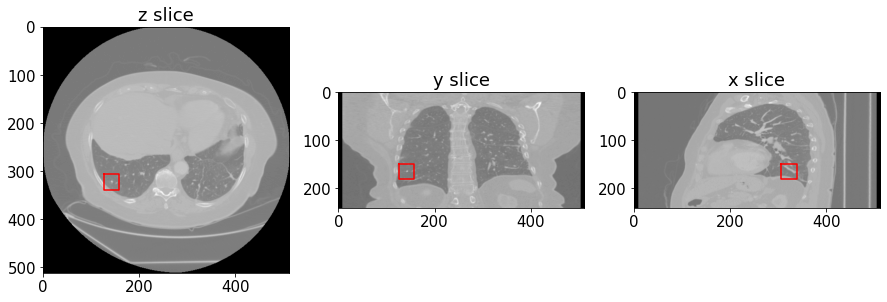

In [31]:
index = 4
row = next(islice(nodules_df.itertuples(), index, index + 1))
print(row)
case = row.case
scan_id = row.scan
dcm_dir_glob = list(data_dir.glob(f"LIDC-IDRI-{case}/*/{scan_id}.*/"))
if len(dcm_dir_glob) == 0:
    raise RuntimeError(
        f"({scan_id=} {case=}): " "Scan not found. Skipping this scan ..."
    )
if len(dcm_dir_glob) > 1:
    raise RuntimeError(
        f"({scan_id=} {case=}): "
        "Found multiple scans with same ids. Skipping this scan ..."
    )
dcm_dir = dcm_dir_glob[0]
xml_files = list(dcm_dir.glob("*.xml"))
if len(xml_files) == 0:
    raise RuntimeError(
        f"({scan_id=} {case=}): "
        "Can't find a XML file. Skipping this scan ..."
    )
elif len(xml_files) > 1:
    raise RuntimeError(
        f"({scan_id=} {case=}): "
        "Found multiple XML files. Skipping this scan ..."
    )
xml_file = xml_files[0]
nodule_ids = row.ids
malignancies = get_malignancies(xml_file, nodule_ids)
print(f"{malignancies = }")
scan = read_dcm(dcm_dir, reverse_z=True)

fig, ax = plt.subplots(nrows=1, ncols=3)

s = 16  # space between the center and the bounding box

plot_slice(scan, axis="z", index=row.zloc, ax=ax[0])
ax[0].plot(
    [row.xloc - s, row.xloc - s, row.xloc + s, row.xloc + s, row.xloc - s],
    [row.yloc - s, row.yloc + s, row.yloc + s, row.yloc - s, row.yloc - s],
    "r-",
)
ax[0].set_title("z slice")

plot_slice(scan, axis="y", index=row.yloc, ax=ax[1])
ax[1].plot(
    [row.xloc - s, row.xloc - s, row.xloc + s, row.xloc + s, row.xloc - s],
    [row.zloc - s, row.zloc + s, row.zloc + s, row.zloc - s, row.zloc - s],
    "r-",
)
ax[1].set_title("y slice")

plot_slice(scan, axis="x", index=row.yloc, ax=ax[2])
ax[2].plot(
    [row.yloc - s, row.yloc - s, row.yloc + s, row.yloc + s, row.yloc - s],
    [row.zloc - s, row.zloc + s, row.zloc + s, row.zloc - s, row.zloc - s],
    "r-",
);
ax[2].set_title("x slice")

patch = extract_patch(scan, (row.zloc, row.yloc, row.xloc), (s, s*2, s*2))
plot_volume_animation(patch, axis="z")